In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [22]:
df = pd.read_csv('JNJ_complete.csv', parse_dates=['Date'], index_col='Date')
print(df.shape)
df.tail()

(1259, 4)


,Open,High,Low,Close
Date,,,,
2021-09-27,164.000000,164.360001,162.850006,163.169998
2021-09-28,163.100006,163.910004,161.770004,162.809998
2021-09-29,163.000000,164.660004,162.779999,164.020004
2021-09-30,164.639999,165.399994,161.410004,161.500000
2021-10-01,161.529999,161.899994,158.619995,160.470001


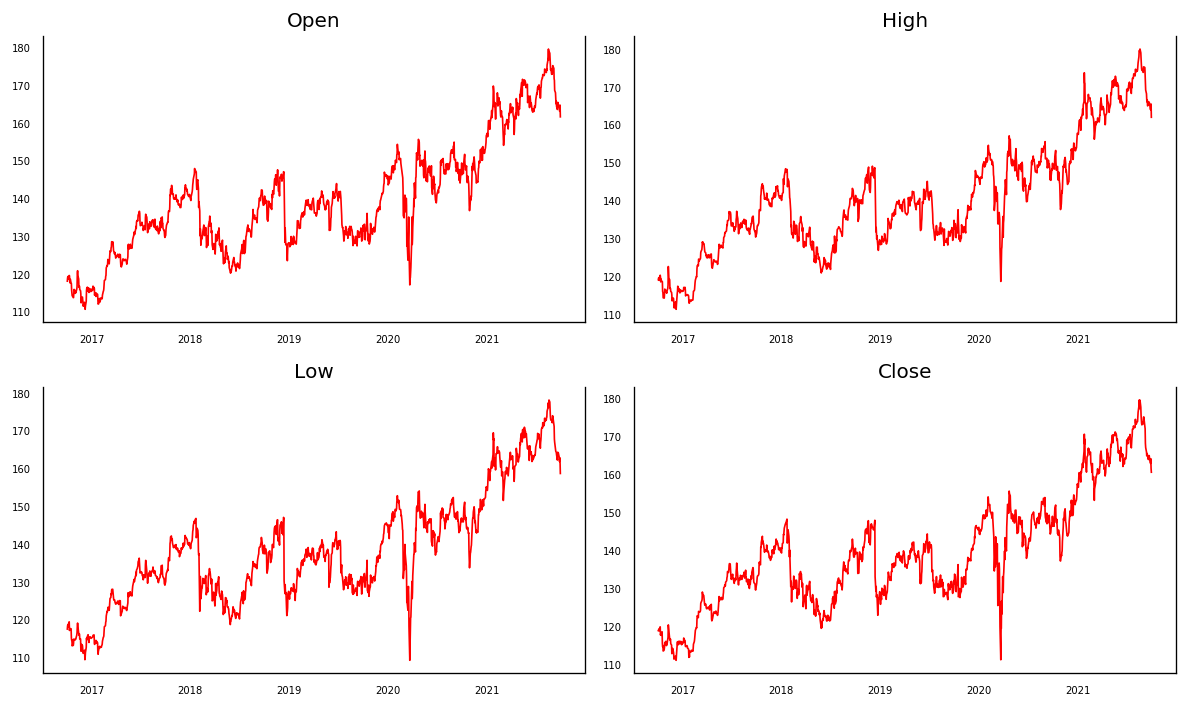

In [23]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [24]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)  

,Open_x,High_x,Low_x,Close_x
Open_y,1.0,0.0000,0.0000,0.0
High_y,0.0,1.0000,0.0000,0.0
Low_y,0.0,0.0000,1.0000,0.0
Close_y,0.0,0.0014,0.0002,1.0


In [25]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Open   ::  480.05    > 40.1749   =>   True
High   ::  226.5     > 24.2761   =>   True
Low    ::  55.71     > 12.3212   =>   True
Close  ::  0.29      > 4.1296    =>   False


In [26]:
nobs = 420
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)
print(df_test.shape)

(839, 4)
(420, 4)


In [27]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  

In [28]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.0378
 No. Lags Chosen       = 0
 Critical value 1%     = -3.438
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.2702. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.0902
 No. Lags Chosen       = 1
 Critical value 1%     = -3.438
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.2485. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Low" 
    -----------------------------------------------
 Null Hypothesis: Data has unit roo

In [29]:
# 1st difference
df_differenced = df_train.diff().dropna()

In [30]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -27.8264
 No. Lags Chosen       = 0
 Critical value 1%     = -3.438
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -26.1505
 No. Lags Chosen       = 0
 Critical value 1%     = -3.438
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Low" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05

In [31]:
model = VAR(df_differenced)
x = model.select_order(maxlags=20)
x.summary()

E:\Anaconda\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


,AIC,BIC,FPE,HQIC
0,-0.01411,0.008908,0.9860,-0.005276
1,-1.639,-1.524,0.1941,-1.595
2,-2.079,-1.872,0.1250,-2.000
3,-2.359,-2.060*,0.09452,-2.244
4,-2.445,-2.054,0.08673,-2.295
5,-2.529,-2.046,0.07972,-2.344
6,-2.569,-1.994,0.07660,-2.348
7,-2.618,-1.950,0.07296,-2.362*
8,-2.651,-1.892,0.07057,-2.360
9,-2.649,-1.798,0.07071,-2.323


In [32]:
model_fitted = model.fit(5)

In [33]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

def adjust(val, length= 6): return str(val).ljust(length)

for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

Open   : 2.04
High   : 2.0
Low    : 2.01
Close  : 1.98


In [34]:
# Get the lag order
lag_order = model_fitted.k_ar

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]

In [35]:
# Forecast
fc = model_fitted.forecast(y = forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index = df.index[-nobs:], columns=df.columns + '_1d')
df_forecast

,Open_1d,High_1d,Low_1d,Close_1d
Date,,,,
2020-02-04,0.549933,0.536767,0.183423,0.184321
2020-02-05,0.076326,-0.044432,-0.234921,-0.279349
2020-02-06,-0.178156,-0.150644,-0.062198,0.134110
2020-02-07,0.120906,-0.046881,0.035972,-0.121863
2020-02-10,0.025453,0.109887,0.220529,0.122134
2020-02-11,0.024308,0.077631,0.070562,0.135099
2020-02-12,0.118247,0.089466,-0.017109,-0.012103
2020-02-13,0.000971,0.013538,-0.027278,0.019681
2020-02-14,0.010840,-0.003042,0.043396,0.041909


In [36]:
def invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [37]:
df_results = invert_transformation(df_train, df_forecast)        

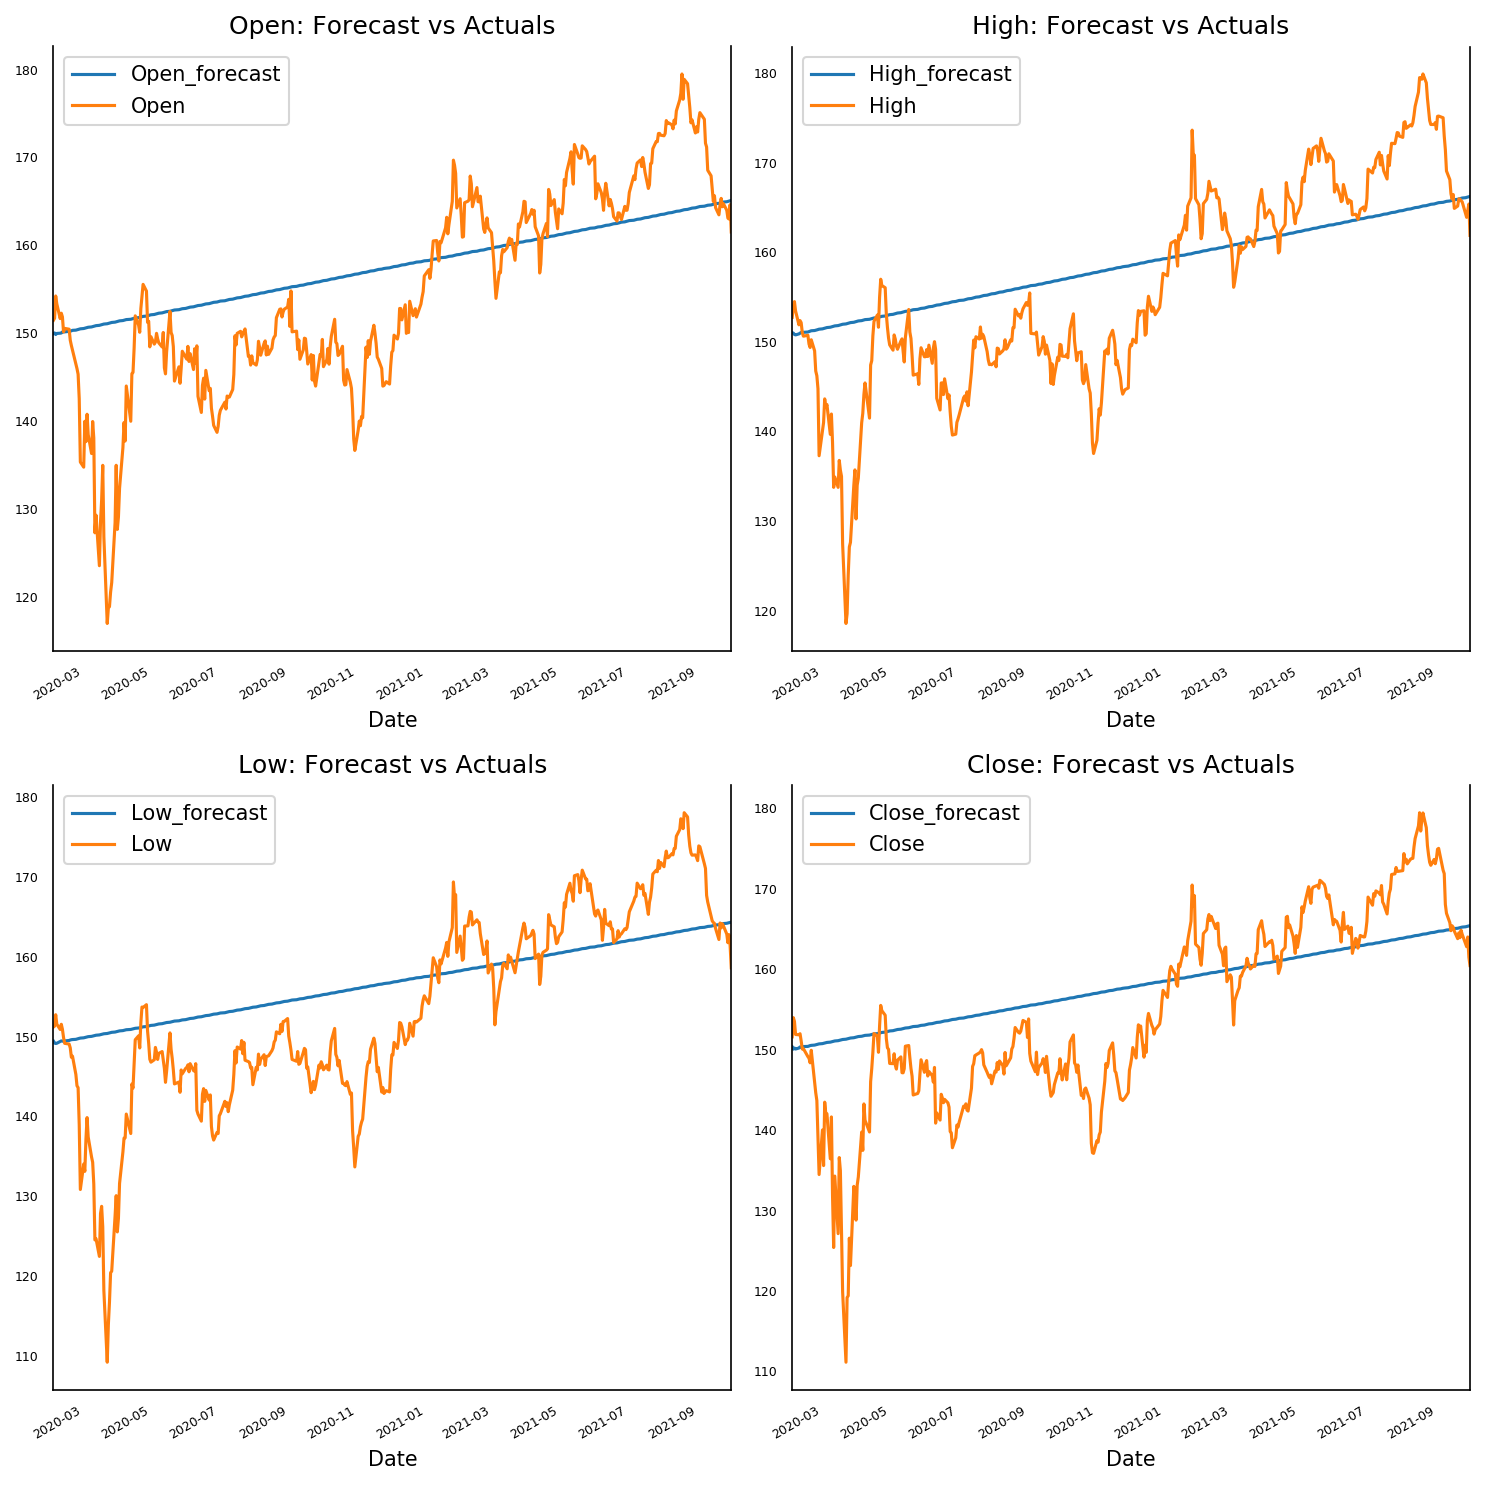

In [38]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [39]:
# make predictions on future dates
pred = model_fitted.forecast(model_fitted.y, steps=nobs)
pred = pd.DataFrame(pred, columns = df.columns+ '_pred')

pred = pd.DataFrame(pred, columns=df.columns+ '_pred')
def invert_transformation(df_differenced, pred):
  forecast = pred.copy()
  columns = df.columns
  for col in columns:
    forecast[str(col)+'_pred'] = df[col].iloc[-1] +   forecast[str(col) +'_pred'].cumsum()
  return forecast

output = invert_transformation(df_differenced, pred)

output = pd.DataFrame(output['Close_pred'])

d = df.tail(nobs)
d.reset_index(inplace = True)
d = d.append(pd.DataFrame({'Date': pd.date_range(start = d.Date.iloc[-1], periods = (len(d) + 1), freq = 'd', closed = 'right')}))
d.set_index('Date', inplace = True)
d = d.tail(nobs)
output.index = d.index
print(output)

            Close_pred
Date                  
2021-10-02  160.654322
2021-10-03  160.374973
2021-10-04  160.509084
2021-10-05  160.387221
2021-10-06  160.509355
2021-10-07  160.644454
2021-10-08  160.632351
2021-10-09  160.652032
2021-10-10  160.693941
2021-10-11  160.711462
2021-10-12  160.763531
2021-10-13  160.812842
2021-10-14  160.842031
2021-10-15  160.875088
2021-10-16  160.911863
2021-10-17  160.945586
2021-10-18  160.986120
2021-10-19  161.024699
2021-10-20  161.059056
2021-10-21  161.095170
2021-10-22  161.131641
2021-10-23  161.168211
2021-10-24  161.205695
2021-10-25  161.242228
2021-10-26  161.278377
2021-10-27  161.314940
2021-10-28  161.351529
2021-10-29  161.388217
2021-10-30  161.424924
2021-10-31  161.461435
...                ...
2022-10-27  174.669908
2022-10-28  174.706496
2022-10-29  174.743085
2022-10-30  174.779674
2022-10-31  174.816262
2022-11-01  174.852851
2022-11-02  174.889439
2022-11-03  174.926028
2022-11-04  174.962617
2022-11-05  174.999205
2022-11-06 

In [42]:
from sklearn.metrics import mean_squared_error
print("MSE: ", mean_squared_error(df_test['Close'], output))

MSE:  246.38566778250242
